# Modelling Motor Imagery BCI with Active Inference

The original paper : [[0]](#0).
Simultaneous MRI-EEG during a motor imagery neurofeedback task: an open access brain imaging dataset for multi-modal data integration
Giulia Lioi, Claire Cury, Lorraine Perronnet, Marsel Mano, Elise Bannier, Anatole Lécuyer,  View ORCID ProfileChristian Barillot
doi: https://doi.org/10.1101/862375

First, let's make a quick summing-up of the result of the original paper, then we'll motivate our approach without getting too far into the details of the model implementation.

Finally, we'll propose a few key simulations to enlighten the results of the original task.

In [1]:
# Let's import the needed packages for further use ! 
import sys,os

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

plt.ioff()

import actynf

# A few helper functions ...
from tools import clever_running_mean
from tools import save_output,extract_training_data

# Loading the experimental measures !
from load_data import load_eeg_scores_xp1


# A FEW CONSTANTS : 
XP1_DATA_PATH = os.path.join("..","..","data","xp1")

# The relative paths of our simulated results and figures : 
SAVING_FOLDER = os.path.join("..","..","simulation_outputs","paper_graz","2_orientation")
FIGURES_FOLDER = os.path.join("figures")

## 1. The orignal task

### Noticeable particularities : 
- **Two imaging techniques :** FMRI (fine spatial resolution, but slow dynamics) & EEG (lower spatial resolution, excellent temporal resolution). It was a technical challenge to integrate both measure simultaneously (+ online processing)
- **Two-dimensional feedback** based on those sensor modalities

### The task itself :
- Motor imagery Neurofeedback task (right hand)
- Sensors : 64 channels EEG + fMRI
- Two sub-studies (XP1 and XP2). XP1 (N=10) compared **unimodal** and **bimodal** Neurofeedback. XP2 (N=20) performed **bimodal** NF with a 1D or 2D feedback.
- Participants : right-handed, naive, 18/12,  (mean age 33.7 ± 9.9 years old). Only 26 in the public dataset.

**Quick definition**
> Motor imagery designates a dynamic mental state duringwhich movements are mentally simulated without actuallyexecuting them, i.e., motor imagery designates the perfor-mance of movements in one’s mind (Decety & Grèzes,1999; Jeannerod,1994). [[2]](#2).

### Experimental paradigms : 

#### XP1. EEG / fMRI / EEG + fMRI

![alt text](resources/xp1_schema.JPG "XP1"){: style="height:320px"}

**Instructions :** (verbally + written at the beginning of each trial) :
> - They were instructed to perform a kinaesthetic motor imagery of the right hand and to find their own strategy to control and bring the ball to the target. 
>
> - They were informed that the NF would be a measure of laterality and that they had to maximize the activity only over the right hand motor region, therefore avoiding to image movements involving the two hands.
>
> - Information about the direction (vertical, horizontal or both) along which the ball could be moved were given


**Trials :** (organized in blocks, 20s rest-20s task)
- 1.  run of motor localization (hand clenching) - 8 blocks
- 2.  run of feedback deprived MI - 5 blocks
- 3.  run of EEG-NF - 10 blocks
- 4.  run of FMRI-NF - 10 block
- 5.  run of EEG/FMRI NF - 10 blocks
- 6.  run of feedback deprived MI - 5 blocks

*Phases 3/4/5 could happen in any order.*

**Biomarkers :**
- fMRI : the left M1 ROI was defined during phase 1 (9x9x3 voxels around the maximum of activation in the motor), and the right M1 ROI was the symmetrical across mid-saggital plane. The resulting laterality index was calculated during training following : $NF_{MRI}=\frac{B_{left}(v)}{B_{left}(rest)} - \frac{B_{right}(v)}{B_{right}(rest)}$, with B the avg of the BOLD signal over the ROI during the trial (v) and at rest. Updated every 2 seconds.
- EEG : EEG power in the 8-12Hz band in electrodes C1+C2 following $NF_{eeg}=\frac{BP_{left}-BP_{right}}{BP_{left}+BP_{right}}$ (Alpha Assymetry Index in the motor area). Updated every 250 ms.

#### XP2. EEG + fMRI | 1D vs 2D feedback

![alt text](resources/xp2_schema.JPG "XP2"){: style="height:320px"}

**Instructions :** (verbally + written at the beginning of each trial) :
> - They were instructed to perform a kinaesthetic motor imagery of the right hand and to find their own strategy to control and bring the ball to the target. 
>
> - They were informed that the NF would be a measure of laterality and that they had to maximize the activity only over the right hand motor region, therefore avoiding to image movements involving the two hands.
>
> - The two NF metaphors (bi-dimensional 2d and unidimensional 1d) were described.


**Trials :** (organized in blocks, 20s rest-20s task)
- 1.  run of feedback deprived MI - 5 blocks
- 2.  3 runs of EEG/FMRI NF with Nmod(subj) - 10 blocks each
- 3.  run of feedback deprived MI - 5 blocks

**Biomarkers :**
- calibration procedure : during phase 1 (*note that this was done during the MIpre phase instead of the motorloc*). EEG data -> Analyzer (Brain Product) -> BCG (ballistocardiogram) correction -> CSP filter to maximize active vs rest. fMRI data -> slice-time correction -> spatial realignment + smoothing -> GLM for activation maps -> ROI are the 9x9x3 voxels around the maximum of activation. No right M1 here.
- fMRI :  The resulting fMRI feedback was calculated during training following : $NF_{MRI}=\frac{B_{ROI}(v)}{B_{ROI}(rest)} - \frac{B_{BG}(v)}{B_{BG}(rest)}$, with $B_{ROI}$ the avg of the BOLD signal over the ROI during the trial (v) and at rest and $B_{BG}$ the BOLD signal in a background deep slice. Updated every 1 second.
- EEG : EEG power in the 8-12Hz band in electrodes C1+C2 following the ERD: $NF_{eeg}=\frac{BP_{left}(rest)-BP_{left}(t)}{BP_{left}(rest)}$ (Event related desynchronization). Updated every 250 ms.


## 2. The model !

We use Active Inference to frame the paradigm in a subject-centric cognitive manner. 

In effect, instead of directly controlling their brain activity, the subjects attempt to regulate its cognition, which leads to changes in the biomarker. Our model attempts to answer a few questions relating to the task : 
- What are the most likely regulated cognitive states ? 
- What is the effect of different temporal scales in the provided feedback ?
- Another ?

Active Inference frames agent perception, action and learning into a single process of energy minimization. This can be implemented into a Categorical HMM architecture, thus simplifying the belief update computations significantly. Because the agent must make decisions, this HMM is also a MDP (Markov Decision Process). This results in a POMDP (Partially Observable Markove Decision Process). 

![alt text](resources/model_mdp.png "POMDP"){: style="height:400px"}

In our approach, agent action selection is based on a tree search algorithm estimating the agent Expected Free Energy along plausible policy paths. This specific approach is called "Sophisticated Inference" [[1]](#1).


But first, we need to constrain our situation a little ! The file "model.py" contains all the necessary material to initialize our models.

We describe the mental states of the subject along a specific number of dimensions (or factors) $Nf$. In our present case, important factors may be more closely defined as, for instance : 
- The intensity of right hand motor stimulation ($MS_r$)
- The intensity of left hand motor stimulation ($MS_l$)
- The global inhibition of motor activity ($Inh$)
- Possibly other factors relevant to the situation (e.g. attention ?) or irrelevant (e.g. anxiety, emotion)

This basic representation is supported by scientific evidence nicely summed up in [[2]](#2).  
- "For instance, motorimagery and motor execution overlap in brain activation(Jeannerod,1994; Porro et al.,1996) and follow similarmovement constraints [...] However, the pro-cesses underlying motor imagery are not entirely the same asthose underlying motor execution. For instance, diﬀerencesin brain activation (Kassess et al.,2008; Kraeutner, Gion-friddo, Bardouille, & Boe,2014; Solodkin, Hlustik, Chen &Small,2004; Guillot, Di Rienzo, MacIntyre, Moran, & Col-let,2012) have been observed." 
- "However, recent studies challenge this idea and show that speciﬁc inhibitory mecha-nisms prevent actual movements in motor imagery (O`Shea& Moran,2018; Rieger et al.2017; Scheil & Liefooghe,2018). Two active inhibitory mechanisms have been identi-ﬁed: global inhibition, i.e., all motor commands are inhib-ited, and selective eﬀector-speciﬁc inhibition, i.e., only theeﬀector used during motor imagery is inhibited (Guillot, DiRienzo et al2012; Rieger et al.,2017)."

In our model, each of these state factors may take an unspecified number of discrete values. For now, we'll instantiate only 3 cognitive dimensions with 5 possible values each (for a total of 125 possible distinct mental states). We write $Ns = [5,5,5]$.

### a. The observation model !

Participants are provided with one or two external observation modalities (the so-called "feedbacks"). Our model formalizes this feedback as a direct correspondance between subject cognition and observations (the Active Inference $\mathbf{A}$ matrix). It also explains subject perception of the feedback by an internal perception belief ($\mathbf{a}$ matrix), attempting to approximate the true generative function.

The feedback modalities have different characteristics linked to the biomarker they're using. One important feature is temporality (every 250ms for EEG, every 1000/2000 ms for fMRI depending on the XP). *We'll address the temporal dimension of the observation modalities later.*

The neurofeedback procedure targets a specific biomarker, and in effect a specific cognitive activity. This can be a single mental state or a collection of mental states denoted $s_{target}$. Assuming that the biomarker is unbiaised, the feedback level is some measure of distance between the the true mental state of the subject $s$ and the target : $o_t = |s_{target},s|$.In the remainder of this study, we'll assume that the feedback level is centered around by the euclidian distance between the true mental state of the subject and the target cognitive subspace :

$o_t \sim N(\mu = N_o(1 - \frac{L_2(s_{target},s_t)}{\max_{\{s\}}(L_2(s_{target},s))}), \sigma)$

Where No is the number of possible observations the subject receives from this modality. Larger values of No allow the subject to receive a finer granularity about its cognitive topography, but (1.) is limited by subject perceptive constraints and (2.) may lead to a greater vulnerability to noise.

Of course, the feedback is affected by some degree of noise. In practice, feedback noise comes from a long list of factors, including but not limited to acquisition, experimental quirks (like subject movements), as well as biomarker imprecisions (unspecificity, individual variations, etc.). For simplicity's sake, we sum it all up into a single noise variable $\sigma$. We denote the noise of each modality with the subsets $EEG$ and $fMRI$. Finally, we differentiate between process (*denoted with the subset $p$* : the true quality of the BCI pipeline) and model (*denoted with the subset $m$* : subject belief about the feedback quality). To sum it up, we have the following four observation-relevant parameters : 
- $\sigma_{EEGp}$ : The true noise of the EEG feedback
- $\sigma_{fMRIp}$ : The true noise of the fMRI feedback
- $\sigma_{EEGm}$ : The subject belief about the noise of the EEG feedback. We will assume $\sigma_{EEGm} = 0.5$ at the beginning of the training.
- $\sigma_{fMRIm}$ : The subject belief about the noise of the fMRI feedback. We will assume $\sigma_{fMRIm} = 0.5$ at the beginning of the training.

![alt text](resources/UnidimensionalFeedback.png "Feedback"){: style="height:300px"}

Returning to our 3 cognitive dimensions, let's consider that the biomarker used reflects only a few dimensions. 

We plot a few feedback matrices below : (feel free to play with the parameters !)

Text(0.5, 0.8, 'Feedback distribution depending on the two first dimensions\n computed based on AAI')

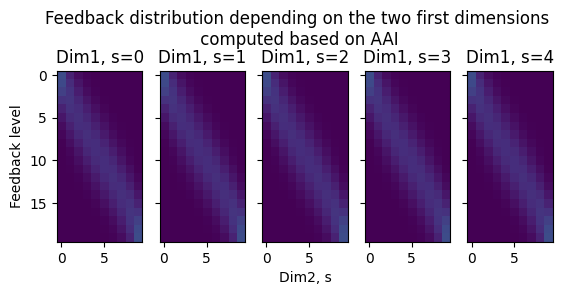

In [2]:
from model import gaussian_from_distance_matrix

Ns_proc = [10,5]   # Intensity of hand movement, right x left x unrelated dimension
No = 20           # Number of discrete feedback levels for each modality
sigma_eeg_m = 3.0  # True feedback std

def distance_matrix_based_on_orientation(_Ns):
    def feedback_laterality(normed_orientation):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        PI = 3.1415
        aai = (np.cos(normed_orientation*PI/2.0) - np.sin(normed_orientation*PI/2.0))/(np.cos(normed_orientation*PI/2.0) + np.sin(normed_orientation*PI/2.0))
        return (aai+1)/2.0  # Normalized

    _dist_mat = np.zeros(tuple(_Ns))
    for idx,val in np.ndenumerate(_dist_mat):
        (ori,intens) = idx
        _dist_mat[idx] = feedback_laterality(ori/(_Ns[0]-1.0))
    return _dist_mat

dist_mat = distance_matrix_based_on_orientation(Ns_proc)
a0 = gaussian_from_distance_matrix(No,dist_mat,sigma_eeg_m)

# Plot this A matrix :
fig,axes = plt.subplots(1,Ns_proc[1],sharey=True)
for state in range(Ns_proc[1]):
    axes[state].imshow(a0[:,:,state],vmin=0,vmax=1)  # For state 0 in the 3rd dimension to avoid clutering
    axes[state].set_title("Dim1, s=" + str(state))
axes[int(Ns_proc[1]/2.0)].set_xlabel("Dim2, s")
axes[0].set_ylabel("Feedback level")
fig.suptitle("Feedback distribution depending on the two first dimensions\n computed based on AAI",y=0.8)


## b. The transition model

**Process :** The transition mapping describes how subjects may perform mental actions to change their cognitive states. This is the main approximation of the model, as these mental actions are poorly understood and rely on a topographical description of the cognitive states (read : a map of the possible mental states subjects can be in, the allowed transitions between them and how they relate to subject actions).

In this modeling approach, we'll make a few broad assumptions :

1. **Continuity :** along a specific mental dimension, one can only move from a state i to the adjacent lower state i-1, higher state i+1 or stay in the same state i. 

2. **Invariablity :** along a specific mental dimension, transitions will generalize along all states. This means that if a transition allows me to increase my attention level from discrete state 0 to discrete state 1, it will similarly allow me to increase my attention level starting from any discrete state. This allows the subject to learn faster by generalizing some part of its knowledge.

3. **Limited actions :** to make action selection less computationally intensive, we'll assume that subjects must 'choose' a dimension to act on, instead of acting on all dimensions simultaneously. This forces agents to maintain a "balancing act" between different dimensions when the feedback is based on multiple cognitive axes.

Contrary to the previous modeling approach, we 

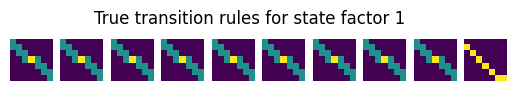

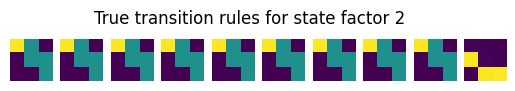

In [3]:
from model import transition_weights_centered

Ns_proc = [7,3]
center_vals = [3,0]
N_up_actions = 1  # number of actions allowing the subject to increase their mental state along a given dim
N_down_actions = 0 # number of actions allowing the subject to decrease their mental state along a given dim
N_neutral_actions = 9 # number of actions neutral with no specific effect regarding a cognitive dimension 
decay_probability = 0.5 # probability of spontaneous cognitive decrease when not picking "up" or "down" actions
effect_probability = 0.99 # probability of a non neutral action performing the transition


B = transition_weights_centered(Ns_proc,
                   N_up_actions,N_down_actions,N_neutral_actions,
                   decay_probability,effect_probability,
                   center_vals)

for factor in range(len(B)):
    Nu = B[factor].shape[-1]
    fig,axes = plt.subplots(1,Nu,sharey=True)
    for action in range(Nu):
        axes[action].imshow(B[factor][:,:,action],vmin=0,vmax=1)
        axes[action].set_axis_off()
    fig.suptitle("True transition rules for state factor "+str(factor+1), y=0.6)

**Transition prior :** For now, we'll assume that our subjects only have a limited understanding of their mental action, through a "sticky" prior matrix 

$b0 = C \mathbf{1} + \gamma Id$

*Where $\mathbf{1}$ is a matrix of ones of dimensions $Ns_{model}[f] \times Ns_{model}[f] \times Nu$, $C$ is the concentration parameter encoding the initial confidence of the subjects in their prior model, Id the identity matrix and $\gamma$ the "stickiness" prior,encoding expectations from the subject that their action may not result in a different cognitive state.*

**Note :** Note that the subject does not have to feature the same number of hidden states the process does. What matters for the framework is that the dimension of the frontier states match. This means that the observations must have the same amount of possible observations, and policies must have the same number of allowable actions.

C:\Users\annic\AppData\Local\Temp\ipykernel_1720\3830006690.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


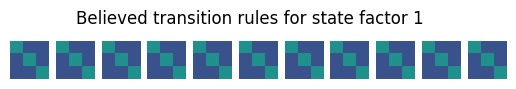

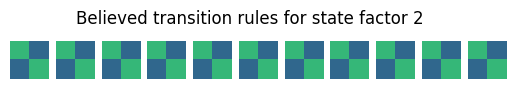

In [4]:
from model import transition_prior

Ns_model = [3,2]
N_up_actions = 1  # number of actions allowing the subject to increase their mental state along a given dim
N_down_actions = 1 # number of actions allowing the subject to decrease their mental state along a given dim
N_neutral_actions = 9 # number of actions neutral with no specific effect regarding a cognitive dimension 
prior_concentration = 1.0 # subject initial confidence about its priors
prior_stickiness = 1.0 # subject initial belief about its actions having no effect on the next state

b = transition_prior(Ns_model,
                   N_up_actions,N_down_actions,N_neutral_actions,
                   prior_concentration,prior_stickiness)
for factor in range(len(b)):
    Nu = b[factor].shape[-1]
    fig,axes = plt.subplots(1,Nu,sharey=True)
    for action in range(Nu):
        axes[action].imshow(actynf.normalize(b[factor][:,:,action]),vmin=0,vmax=1)
        axes[action].set_axis_off()
    fig.suptitle("Believed transition rules for state factor "+str(factor+1), y=0.6)
    fig.show()

## 3. Simulating training with feedback

With 'active_pynference', our public package, we may define a network of *layers* that either generate new observations following an action, or perform Sophisticated Inference to make sense of a dynamic system. We provide a specific wrapper in the *model.py* file to build the network from the basic set of parameters described above so that we may go straight to the simulations !

C:\Users\annic\AppData\Local\Temp\ipykernel_1720\2983265139.py:227: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


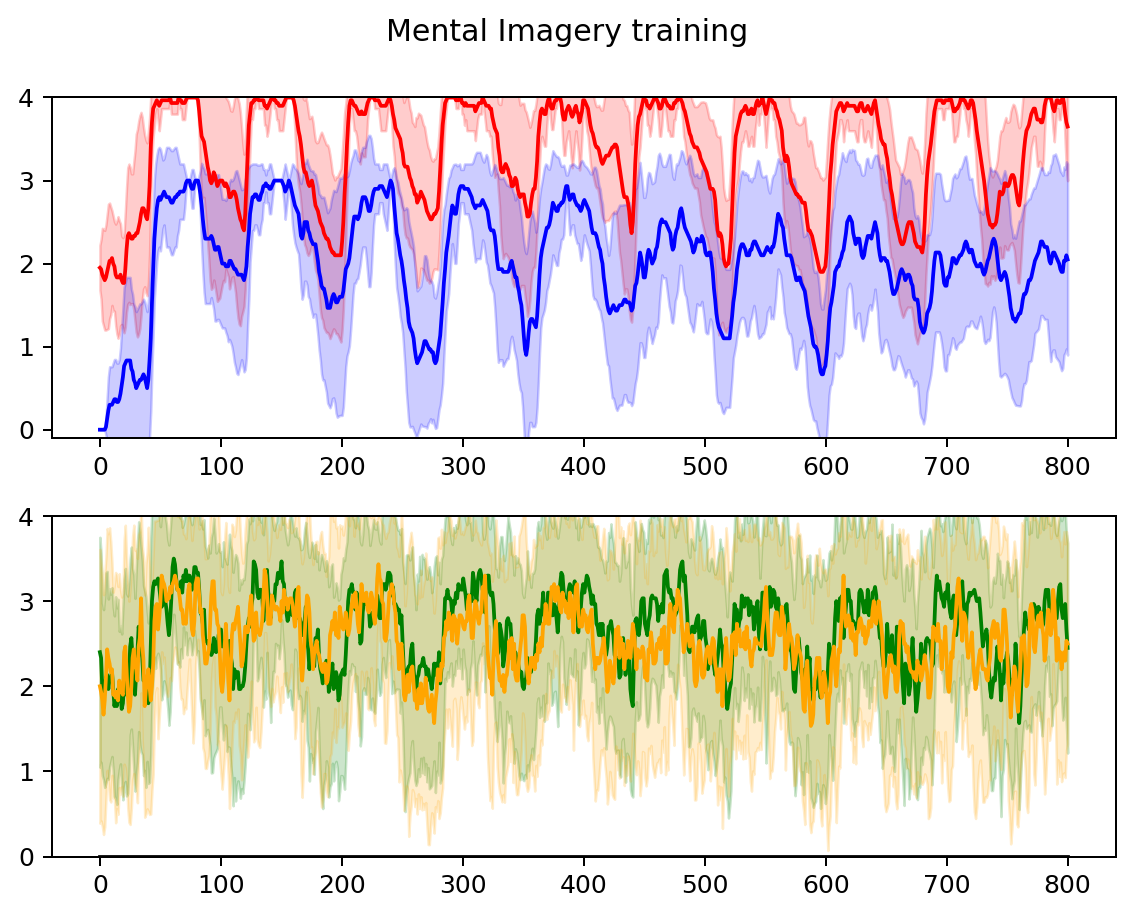

In [5]:
from model import nf_net_dist as nf_phase_layer
from model import rest_phase_layer

from tools import to_list_of_one_hots
import copy

# Loading the experimental values we're trying to match
names,scores,ts = load_eeg_scores_xp1(XP1_DATA_PATH,"eeg")



REST_CST = 0.01
def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        rh_mi = normed_intensity*np.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        lh_mi = normed_intensity*np.sin(normed_orientation*PI/2.0) + rest_cst
        return rh_mi,lh_mi

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_erd,lh_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  - (rh_erd - lh_erd)/(lh_erd + rh_erd)  # Minus
        return (aai+1)/2.0  # Normalized to 0 -> 1

def get_erd(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based on the intensity of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_mi,lh_mi = ERDs(normed_orientation,normed_intensity,krest)
        erd_estimate = (rh_mi - krest)/krest
        return erd_estimate  # Normalized to 0 -> 1

def distance_matrix_based_on_laterality(_Ns,krest=0.01,linear_dependence_on_intensity = False):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                normed_laterality = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                normed_intensity = intens/(_Ns[1]-1.0)

                aai = get_aai(normed_laterality,normed_intensity,REST_CST)
                if linear_dependence_on_intensity :
                        aai = aai * normed_intensity
                        if normed_intensity < 0.1 :
                                aai = -1
                _dist_mat[idx] = 1.0 - aai
        return _dist_mat

def distance_matrix_based_on_intensity(_Ns,krest=0.01,bypass_orientation=None):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                norm_ori = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                intensity = intens/(_Ns[1]-1.0)

                _dist_mat[idx] = get_erd(intensity,norm_ori,REST_CST)
        return _dist_mat


def training(Ntrials,_network_rest,_network_nf):
        """
        A function to describe the training procedure : 
        """
        return_stm,return_weights = [],[]

        
        def communicate(from_net,from_stm,to_net):
                # The last state of the previous iteration becomes the first of the next
                # We also transfer the learnt matrices !
                to_net.layers[1].b = copy.deepcopy(from_net.layers[1].b)
                to_net.layers[1].d = copy.deepcopy(from_net.layers[1].d)
                to_net.layers[0].d = to_list_of_one_hots(from_stm[0].x[:,-1],to_net.layers[0].Ns)

        # We gather the initial weights of the layer at index 0
        return_weights.append(_network_nf.get_current_layers_weights())
        return_stm.append(None) # To match the indices
        for trial in range(Ntrials):
                # Phase 1 : rest !
                # Assume the agent picked actions randomly and the provide:
                rest_stm,rest_wght = _network_rest.run(False,return_STMs=True,return_weights=True)
                
                # Ensure layer continuity between phases.
                communicate(_network_rest,rest_stm,_network_nf)

                nf_stm,nf_wght = _network_nf.run(False,return_STMs=True,return_weights=True)

                # Ensure layer continuity between phases.
                communicate(_network_nf,nf_stm,_network_rest)

                return_stm.append(rest_stm)
                return_stm.append(nf_stm)

                return_weights.append(rest_wght)
                return_weights.append(nf_wght)
        
        return return_stm,return_weights

T = 40  # The amount of timesteps for a specific trial
        # 20 s / 250 ms = 80 timesteps
Ntrials = 10   # 10 blocks x 3 phases
Nsubjects = 10

Th = 2  # Action planning temporal horizon
Ns_proc,Ns_subj = [5,4],[5,4]
resting_states = [int(Ns_proc[0]/2.0),0,0]
Nos = [5,5] # A single feedback with 10 distinct possible observations

# Defining the feedback properties
sigmas_proc = [1.5,1.5] # The true feedback is quite noisy
true_dist_mat = [distance_matrix_based_on_laterality(Ns_proc,linear_dependence_on_intensity = False),distance_matrix_based_on_intensity(Ns_proc)]

sigmas_subj = [0.5] # The subject expects the feedback to be not that noisy
belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = True)]
observation_concentration,observation_stickiness = 1.0,100.0

# Defining the mental states properties
N_up_actions,N_down_actions,N_neutral_actions = 1,1,10
p_decay,p_effect = 0.05,0.99
transition_concentration,transition_stickiness = 1.0,1.0, # 0.01,0.01 if we want to prompt explor !
b_pre = [10.0,10.0]#[3.0*transition_concentration,1.0*transition_concentration]

network_during_nftraining = nf_phase_layer(T,Th,
        Ns_proc,Ns_subj,Nos,
        sigmas_proc,true_dist_mat,
        sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
        N_up_actions,N_down_actions,N_neutral_actions,
        p_decay,p_effect,
        transition_concentration,transition_stickiness,
        learning_space_structure=actynf.LINEAR,gen_temp=3.0,
        resting_state_per_factor=resting_states,
        b_pre=b_pre)

network_during_rest = rest_phase_layer(T,Th,
    Ns_proc,Ns_subj,Nos,
    sigmas_proc,true_dist_mat, 
    sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
    N_up_actions,N_down_actions,N_neutral_actions,
    p_decay,p_effect,
    transition_concentration,transition_stickiness,
    learning_space_structure=actynf.LINEAR,gen_temp=3.0,
    resting_state_per_factor=resting_states,
    b_pre=b_pre)

# for factor in range(Ns_proc[1]):
#         fig,axes = plt.subplots(1,2)
#         axes[0].imshow(actynf.normalize(network_during_nftraining.layers[0].a[0][:,:,factor]),vmin=0,vmax=1)
#         axes[1].imshow(actynf.normalize(network_during_nftraining.layers[1].a[0][:,:,factor]),vmin=0,vmax=1)
#         fig.show()

override = False
savepath = os.path.join(SAVING_FOLDER,"simu_01.simu")

# This is a straight forward run ! 
exists = os.path.isfile(savepath)
if (not(exists)) or (override):
        stm_subjs,weight_subjs = [],[]
        for sub in range(Nsubjects):
                print("Subject " + str(sub) + " / " + str(Nsubjects))
                subj_net = network_during_nftraining.copy_network(sub)
                rest_net = network_during_rest.copy_network(sub)
                STMs,weights = training(Ntrials,rest_net,subj_net)
                stm_subjs.append(STMs)
                weight_subjs.append(weights)
        save_output(stm_subjs,weight_subjs,savepath)

_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

arr_feedback_levels = np.array([[_stm[subj][trial][0].o[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the measured feedbacks ! (modality 0 : laterality, modality 1 : nf)
arr_state_levels = np.array([[_stm[subj][trial][0].x[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
arr_state_belief_levels = np.array([[_stm[subj][trial][1].x_d for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)

window = 1

# Mean of all subjects
fig1,axes1 = plt.subplots(2,1,dpi=180)
colorlist = ["red","blue"]
for f in range(len(Ns_proc)):
        color = colorlist[f]
        states = arr_state_levels[:,:,f,:]
        flat_state_f = states.reshape(states.shape[0],-1)
        m_state = clever_running_mean(np.mean(flat_state_f,axis=0),window)
        v_state = clever_running_mean(np.std(flat_state_f,axis=0),window)
        xs = np.linspace(0,m_state.shape[0],m_state.shape[0])
        axes1[0].fill_between(xs,m_state-v_state,m_state+v_state,color=color,alpha=0.2)
        axes1[0].plot(xs,m_state,color=color)
axes1[0].set_ylim([-0.1,max(Ns_proc)-1])

colorlist = ["green","orange","black"]

for mod in range(arr_feedback_levels.shape[2]):
        color = colorlist[mod]
        observations = arr_feedback_levels[:,:,mod,:]
        flat_fb_lvl = observations.reshape(observations.shape[0],-1)
        m_fb = clever_running_mean(np.mean(flat_fb_lvl,axis=0),window)
        v_fb = clever_running_mean(np.std(flat_fb_lvl,axis=0),window)
        xs = np.linspace(0,m_fb.shape[0],m_fb.shape[0])
        axes1[1].fill_between(xs,m_fb-v_fb,m_fb+v_fb,color=color,alpha=0.2)
        axes1[1].plot(xs,m_fb,color=color)
axes1[1].set_ylim([0,max(Nos)-1])
fig1.tight_layout()
fig1.suptitle("Mental Imagery training",y=1.05)
fig1.show()


# # Compare simulations to actual subject results !
# for stm,weight in zip(_stm,_weight):
#         # Plotting the measured values:
#         subj_id = 1


#         # Plotting simulated : 
#         xs = np.linspace(0,400,Ntrials*2*T)

        
#         fig,axes = plt.subplots(3,1,dpi=180)

#         # Plot the states
#         all_states = np.array([stm[trial][0].x for trial in range(1,len(stm))])
#         print(all_states.shape)
#         all_states = np.swapaxes(all_states,0,1)
#         all_states = all_states.reshape(all_states.shape[0],-1)
#         # Orientation factor : 
#         axes[0].plot(xs,2*clever_running_mean(all_states[0,:],window)/(Ns_proc[0]-1) -1,label="Orientation")
#         # Intensity factor : 
#         axes[0].plot(xs,clever_running_mean(all_states[1,:],window)/(Ns_proc[1]-1),label="Intensity")


#         # Plot the simulated feedback levels, and compare them to experimental results
#         all_feedbacks = np.array([stm[trial][0].o for trial in range(1,len(stm))])
#         all_fbs = np.swapaxes(all_feedbacks,0,1)
#         all_fbs = all_fbs.reshape(all_fbs.shape[0],-1)

#         # Orientation feedback
#         axes[1].plot(xs,(2*clever_running_mean(all_fbs[0,:],window)/(Nos[0]-1)-1),alpha=0.5)
#         axes[1].plot(np.linspace(0,400,scores[subj_id][2].shape[0]),scores[subj_id][2],alpha=0.5)

#         # Intensity feedback
#         axes[2].plot(xs,(2*clever_running_mean(all_fbs[1,:],window)/(Nos[1]-1)-1),alpha=0.5,label="simulated nf")
#         axes[2].plot(np.linspace(0,400,scores[subj_id][3].shape[0]), np.clip(scores[subj_id][3],-1,1),alpha=0.5,label="measured nf")

#         for ax in axes :
#                 ax.grid()
#                 ax.legend()
#         fig.show()

#         print(all_fbs.shape)

Answering a few questions : 
1. Assuming that the subject are quite confident in the feedback, what is the reliability of the biomarker ?
2. 

C:\Users\annic\AppData\Local\Temp\ipykernel_1720\2906357577.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


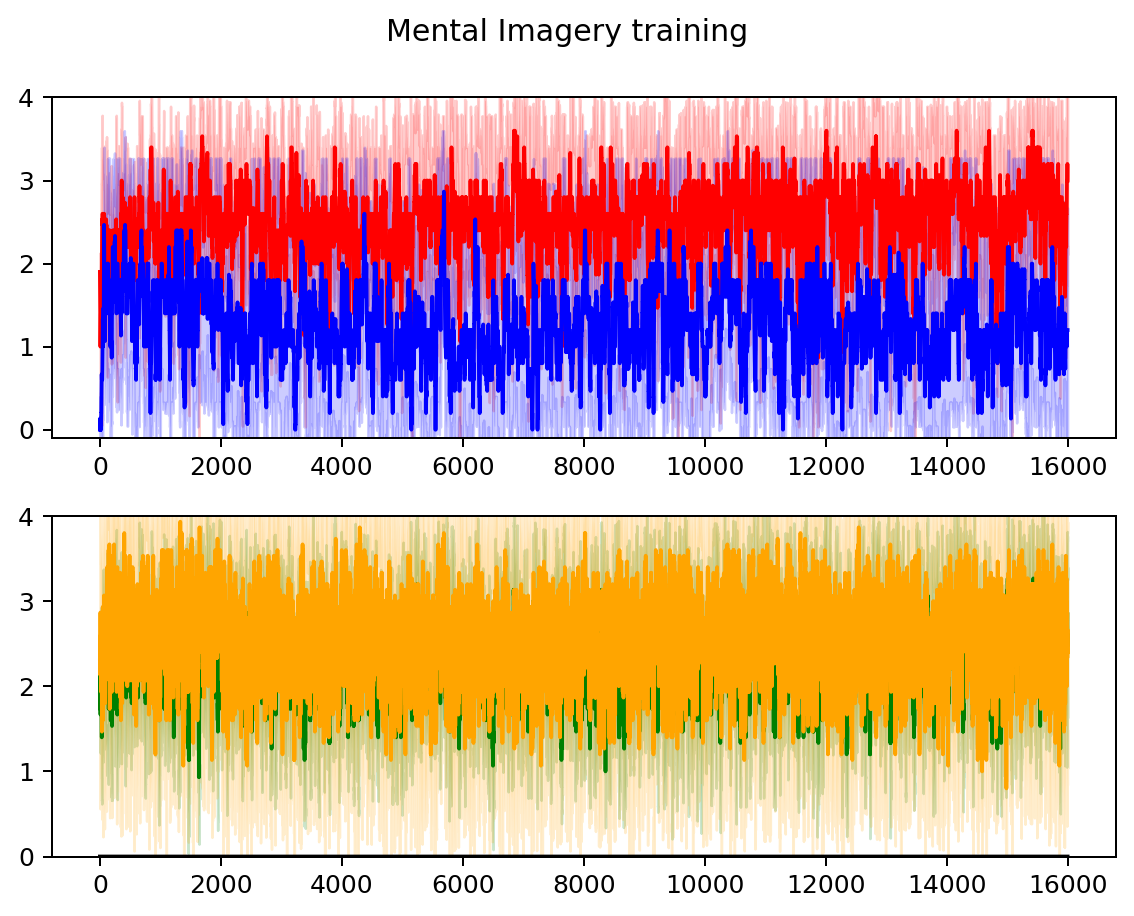

In [6]:
from model import nf_net_dist as nf_phase_layer
from model import rest_phase_layer

from tools import to_list_of_one_hots
import copy

# Loading the experimental values we're trying to match
names,scores,ts = load_eeg_scores_xp1(XP1_DATA_PATH,"eeg")

REST_CST = 0.01
def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        rh_mi = normed_intensity*np.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        lh_mi = normed_intensity*np.sin(normed_orientation*PI/2.0) + rest_cst
        return rh_mi,lh_mi

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_erd,lh_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  - (rh_erd - lh_erd)/(lh_erd + rh_erd)  # Minus
        return (aai+1)/2.0  # Normalized to 0 -> 1

def get_erd(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based on the intensity of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_mi,lh_mi = ERDs(normed_orientation,normed_intensity,krest)
        erd_estimate = (rh_mi - krest)/krest
        return erd_estimate  # Normalized to 0 -> 1

def distance_matrix_based_on_laterality(_Ns,krest=0.01,linear_dependence_on_intensity = False):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                normed_laterality = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                normed_intensity = intens/(_Ns[1]-1.0)

                aai = get_aai(normed_laterality,normed_intensity,REST_CST)
                if linear_dependence_on_intensity :
                        aai = aai * normed_intensity
                        if normed_intensity < 0.1 :
                                aai = -1
                _dist_mat[idx] = 1.0 - aai
        return _dist_mat

def distance_matrix_based_on_intensity(_Ns,krest=0.01,bypass_orientation=None):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                norm_ori = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                intensity = intens/(_Ns[1]-1.0)

                _dist_mat[idx] = get_erd(intensity,norm_ori,REST_CST)
        return _dist_mat


def training(Ntrials,_network_rest,_network_nf):
        """
        A function to describe the training procedure : 
        """
        return_stm,return_weights = [],[]

        
        def communicate(from_net,from_stm,to_net):
                # The last state of the previous iteration becomes the first of the next
                # We also transfer the learnt matrices !
                to_net.layers[1].b = copy.deepcopy(from_net.layers[1].b)
                to_net.layers[1].d = copy.deepcopy(from_net.layers[1].d)
                to_net.layers[0].d = to_list_of_one_hots(from_stm[0].x[:,-1],to_net.layers[0].Ns)

        # We gather the initial weights of the layer at index 0
        return_weights.append(_network_nf.get_current_layers_weights())
        return_stm.append(None) # To match the indices
        for trial in range(Ntrials):
                # Phase 1 : rest !
                # Assume the agent picked actions randomly and the provide:
                rest_stm,rest_wght = _network_rest.run(False,return_STMs=True,return_weights=True)
                
                # Ensure layer continuity between phases.
                communicate(_network_rest,rest_stm,_network_nf)

                nf_stm,nf_wght = _network_nf.run(False,return_STMs=True,return_weights=True)

                # Ensure layer continuity between phases.
                communicate(_network_nf,nf_stm,_network_rest)

                return_stm.append(rest_stm)
                return_stm.append(nf_stm)

                return_weights.append(rest_wght)
                return_weights.append(nf_wght)
        
        return return_stm,return_weights

T = 40  # The amount of timesteps for a specific trial
        # 20 s / 250 ms = 80 timesteps
Ntrials = 200   # 10 blocks x 3 phases
Nsubjects = 5

Th = 2  # Action planning temporal horizon
Ns_proc,Ns_subj = [5,4],[5,4]
resting_states = [int(Ns_proc[0]/2.0),0,0]
Nos = [5,5] # A single feedback with 10 distinct possible observations

# Defining the feedback properties
sigmas_proc = [1.5,1.5] # The true feedback is quite noisy
true_dist_mat = [distance_matrix_based_on_laterality(Ns_proc,linear_dependence_on_intensity = False),distance_matrix_based_on_intensity(Ns_proc)]

sigmas_subj = [0.5] # The subject expects the feedback to be not that noisy
belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = True)]
observation_concentration,observation_stickiness = 1.0,100.0

# Defining the mental states properties
N_up_actions,N_down_actions,N_neutral_actions = 1,1,10
p_decay,p_effect = 0.05,0.99
transition_concentration,transition_stickiness = 1.0,1.0
b_pre = [0.05,0.3]#[3.0*transition_concentration,1.0*transition_concentration]

network_during_nftraining = nf_phase_layer(T,Th,
        Ns_proc,Ns_subj,Nos,
        sigmas_proc,true_dist_mat,
        sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
        N_up_actions,N_down_actions,N_neutral_actions,
        p_decay,p_effect,
        transition_concentration,transition_stickiness,
        learning_space_structure=actynf.LINEAR,gen_temp=3.0,
        resting_state_per_factor=resting_states,
        b_pre=b_pre)

network_during_rest = rest_phase_layer(T,Th,
    Ns_proc,Ns_subj,Nos,
    sigmas_proc,true_dist_mat, 
    sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
    N_up_actions,N_down_actions,N_neutral_actions,
    p_decay,p_effect,
    transition_concentration,transition_stickiness,
    learning_space_structure=actynf.LINEAR,gen_temp=3.0,
    resting_state_per_factor=resting_states,
    b_pre=b_pre)

# for factor in range(Ns_proc[1]):
#         fig,axes = plt.subplots(1,2)
#         axes[0].imshow(actynf.normalize(network_during_nftraining.layers[0].a[0][:,:,factor]),vmin=0,vmax=1)
#         axes[1].imshow(actynf.normalize(network_during_nftraining.layers[1].a[0][:,:,factor]),vmin=0,vmax=1)
#         fig.show()

override = False
savepath = os.path.join(SAVING_FOLDER,"simu_02.simu")

# This is a straight forward run ! 
exists = os.path.isfile(savepath)
if (not(exists)) or (override):
        stm_subjs,weight_subjs = [],[]
        for sub in range(Nsubjects):
                print("Subject " + str(sub) + " / " + str(Nsubjects))
                subj_net = network_during_nftraining.copy_network(sub)
                rest_net = network_during_rest.copy_network(sub)
                STMs,weights = training(Ntrials,rest_net,subj_net)
                stm_subjs.append(STMs)
                weight_subjs.append(weights)
        save_output(stm_subjs,weight_subjs,savepath)

_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

arr_feedback_levels = np.array([[_stm[subj][trial][0].o[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the measured feedbacks ! (modality 0 : laterality, modality 1 : nf)
arr_state_levels = np.array([[_stm[subj][trial][0].x[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
arr_state_belief_levels = np.array([[_stm[subj][trial][1].x_d for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)

window = 1

# Mean of all subjects
fig1,axes1 = plt.subplots(2,1,dpi=180)
colorlist = ["red","blue"]
for f in range(len(Ns_proc)):
        color = colorlist[f]
        states = arr_state_levels[:,:,f,:]
        flat_state_f = states.reshape(states.shape[0],-1)
        m_state = clever_running_mean(np.mean(flat_state_f,axis=0),window)
        v_state = clever_running_mean(np.std(flat_state_f,axis=0),window)
        xs = np.linspace(0,m_state.shape[0],m_state.shape[0])
        axes1[0].fill_between(xs,m_state-v_state,m_state+v_state,color=color,alpha=0.2)
        axes1[0].plot(xs,m_state,color=color)
axes1[0].set_ylim([-0.1,max(Ns_proc)-1])

colorlist = ["green","orange","black"]

for mod in range(arr_feedback_levels.shape[2]):
        color = colorlist[mod]
        observations = arr_feedback_levels[:,:,mod,:]
        flat_fb_lvl = observations.reshape(observations.shape[0],-1)
        m_fb = clever_running_mean(np.mean(flat_fb_lvl,axis=0),window)
        v_fb = clever_running_mean(np.std(flat_fb_lvl,axis=0),window)
        xs = np.linspace(0,m_fb.shape[0],m_fb.shape[0])
        axes1[1].fill_between(xs,m_fb-v_fb,m_fb+v_fb,color=color,alpha=0.2)
        axes1[1].plot(xs,m_fb,color=color)
axes1[1].set_ylim([0,max(Nos)-1])
fig1.tight_layout()
fig1.suptitle("Mental Imagery training",y=1.05)
fig1.show()


# # Compare simulations to actual subject results !
# for stm,weight in zip(_stm,_weight):
        # Plotting the measured values:
        # subj_id = 1


        # # Plotting simulated : 
        # xs = np.linspace(0,400,Ntrials*2*T)

        
        # fig,axes = plt.subplots(3,1,dpi=180)

        # # Plot the states
        # all_states = np.array([stm[trial][0].x for trial in range(1,len(stm))])
        # print(all_states.shape)
        # all_states = np.swapaxes(all_states,0,1)
        # all_states = all_states.reshape(all_states.shape[0],-1)
        # # Orientation factor : 
        # axes[0].plot(xs,2*clever_running_mean(all_states[0,:],window)/(Ns_proc[0]-1) -1,label="Orientation")
        # # Intensity factor : 
        # axes[0].plot(xs,clever_running_mean(all_states[1,:],window)/(Ns_proc[1]-1),label="Intensity")


        # # Plot the simulated feedback levels, and compare them to experimental results
        # all_feedbacks = np.array([stm[trial][0].o for trial in range(1,len(stm))])
        # all_fbs = np.swapaxes(all_feedbacks,0,1)
        # all_fbs = all_fbs.reshape(all_fbs.shape[0],-1)

        # # Orientation feedback
        # axes[1].plot(xs,(2*clever_running_mean(all_fbs[0,:],window)/(Nos[0]-1)-1),alpha=0.5)
        # axes[1].plot(np.linspace(0,400,scores[subj_id][2].shape[0]),scores[subj_id][2],alpha=0.5)

        # # Intensity feedback
        # axes[2].plot(xs,(2*clever_running_mean(all_fbs[1,:],window)/(Nos[1]-1)-1),alpha=0.5,label="simulated nf")
        # axes[2].plot(np.linspace(0,400,scores[subj_id][3].shape[0]), np.clip(scores[subj_id][3],-1,1),alpha=0.5,label="measured nf")

        # for ax in axes :
        #         ax.grid()
        #         ax.legend()
        # fig.show()

        # print(all_fbs.shape)

C:\Users\annic\AppData\Local\Temp\ipykernel_1720\1709983510.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
C:\Users\annic\AppData\Local\Temp\ipykernel_1720\1709983510.py:244: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\annic\AppData\Local\Temp\ipykernel_1720\1709983510.py:245: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


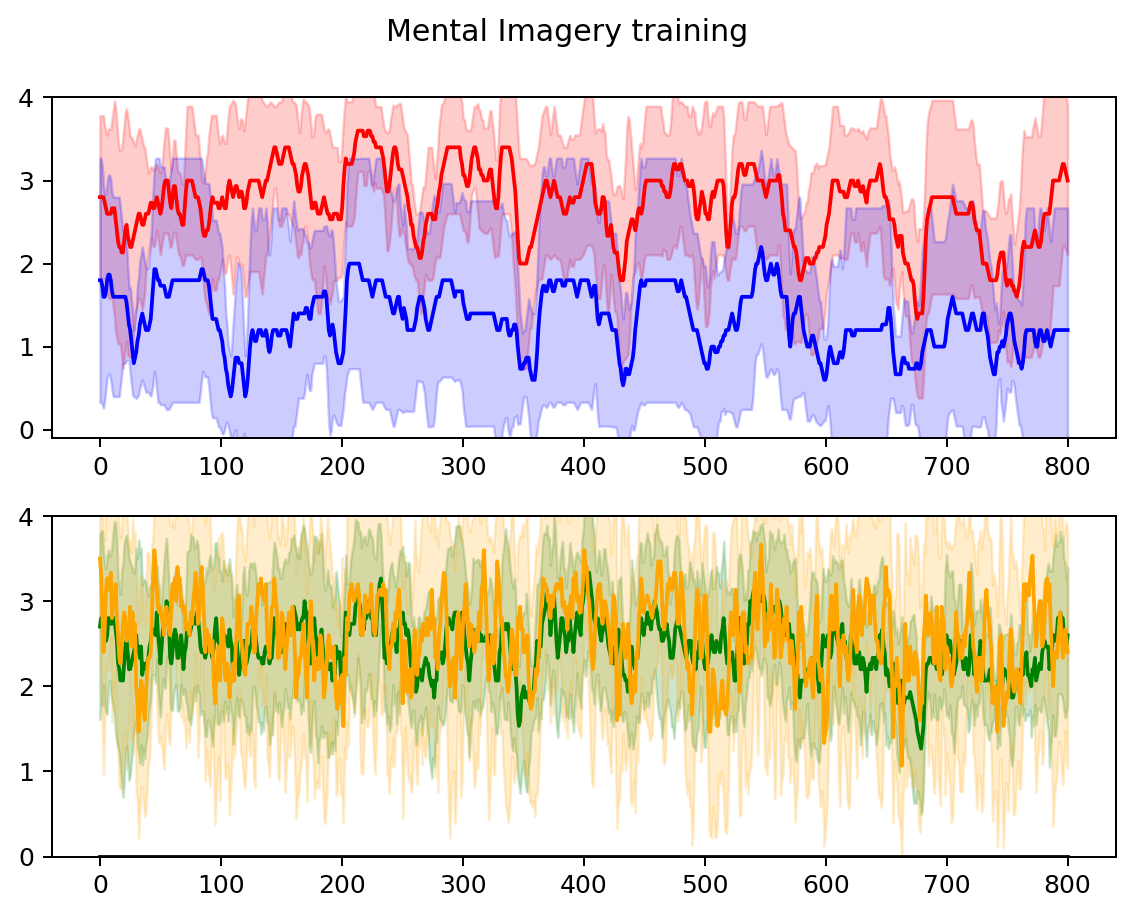

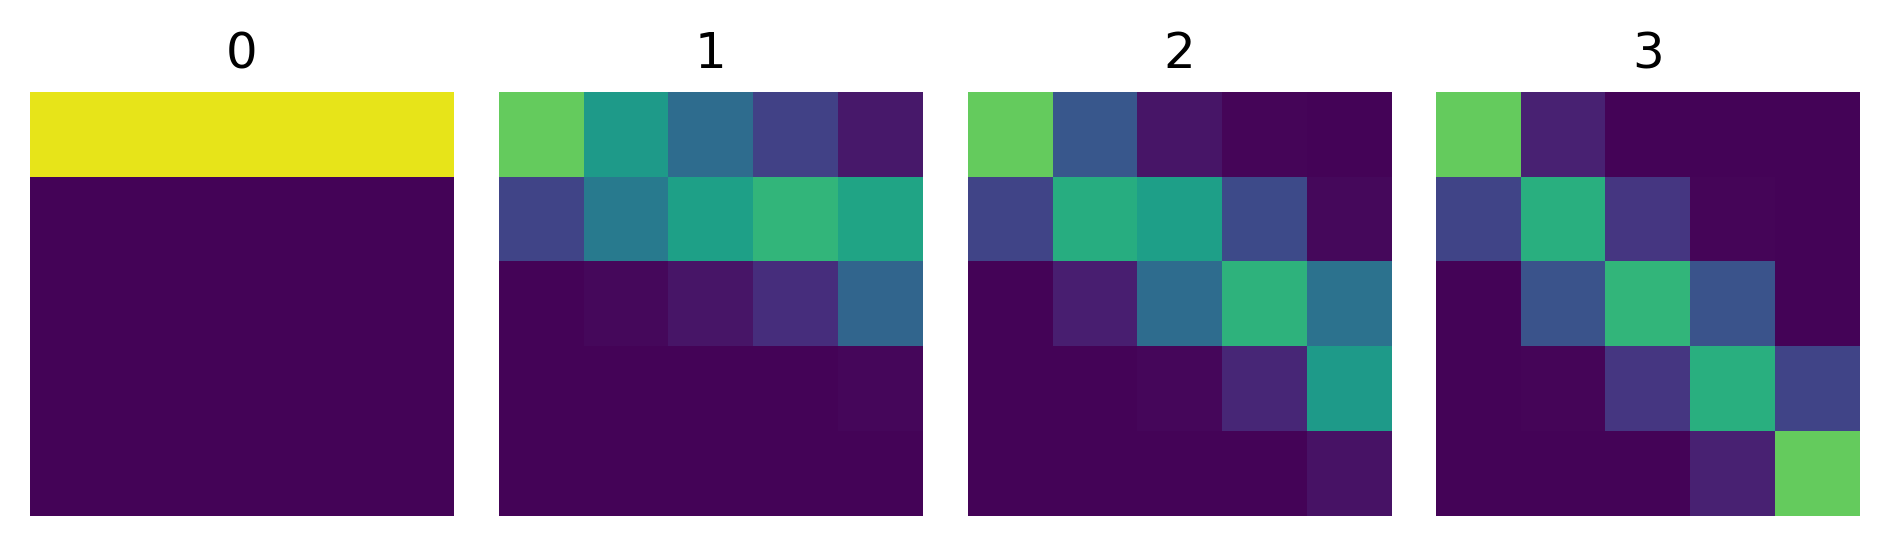

In [11]:
from model import nf_net_dist as nf_phase_layer
from model import rest_phase_layer

from tools import to_list_of_one_hots
import copy

# Loading the experimental values we're trying to match
names,scores,ts = load_eeg_scores_xp1(XP1_DATA_PATH,"eeg")



REST_CST = 0.01
def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        rh_mi = normed_intensity*np.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        lh_mi = normed_intensity*np.sin(normed_orientation*PI/2.0) + rest_cst
        return rh_mi,lh_mi

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_erd,lh_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  - (rh_erd - lh_erd)/(lh_erd + rh_erd)  # Minus
        return (aai+1)/2.0  # Normalized to 0 -> 1

def get_erd(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based on the intensity of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_mi,lh_mi = ERDs(normed_orientation,normed_intensity,krest)
        erd_estimate = (rh_mi - krest)/krest
        return erd_estimate  # Normalized to 0 -> 1

def distance_matrix_based_on_laterality(_Ns,krest=0.01,linear_dependence_on_intensity = False):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                normed_laterality = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                normed_intensity = intens/(_Ns[1]-1.0)

                aai = get_aai(normed_laterality,normed_intensity,REST_CST)
                if linear_dependence_on_intensity :
                        aai = aai * normed_intensity
                        if normed_intensity < 0.1 :
                                aai = -1
                _dist_mat[idx] = 1.0 - aai
        return _dist_mat

def distance_matrix_based_on_intensity(_Ns,krest=0.01,bypass_orientation=None):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                norm_ori = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                intensity = intens/(_Ns[1]-1.0)

                _dist_mat[idx] = get_erd(intensity,norm_ori,REST_CST)
        return _dist_mat


def training(Ntrials,_network_rest,_network_nf):
        """
        A function to describe the training procedure : 
        """
        return_stm,return_weights = [],[]

        
        def communicate(from_net,from_stm,to_net):
                # The last state of the previous iteration becomes the first of the next
                # We also transfer the learnt matrices !
                to_net.layers[1].b = copy.deepcopy(from_net.layers[1].b)
                to_net.layers[1].d = copy.deepcopy(from_net.layers[1].d)
                to_net.layers[0].d = to_list_of_one_hots(from_stm[0].x[:,-1],to_net.layers[0].Ns)

        # We gather the initial weights of the layer at index 0
        return_weights.append(_network_nf.get_current_layers_weights())
        return_stm.append(None) # To match the indices
        for trial in range(Ntrials):
                # Phase 1 : rest !
                # Assume the agent picked actions randomly and the provide:
                rest_stm,rest_wght = _network_rest.run(False,return_STMs=True,return_weights=True)
                
                # Ensure layer continuity between phases.
                communicate(_network_rest,rest_stm,_network_nf)

                nf_stm,nf_wght = _network_nf.run(False,return_STMs=True,return_weights=True)

                # Ensure layer continuity between phases.
                communicate(_network_nf,nf_stm,_network_rest)

                return_stm.append(rest_stm)
                return_stm.append(nf_stm)

                return_weights.append(rest_wght)
                return_weights.append(nf_wght)
        
        return return_stm,return_weights

T = 40  # The amount of timesteps for a specific trial
        # 20 s / 250 ms = 80 timesteps
Ntrials = 200   # 10 blocks x 3 phases
Nsubjects = 5

Th = 2  # Action planning temporal horizon
Ns_proc,Ns_subj = [5,4],[5,4]
resting_states = [int(Ns_proc[0]/2.0),0,0]
Nos = [5,5] # A single feedback with 10 distinct possible observations

# Defining the feedback properties
sigmas_proc = [0.5,0.5] # The true feedback is quite noisy
true_dist_mat = [distance_matrix_based_on_laterality(Ns_proc,linear_dependence_on_intensity = False),distance_matrix_based_on_intensity(Ns_proc)]

sigmas_subj = [0.5] # The subject expects the feedback to be not that noisy
belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = True)]
observation_concentration,observation_stickiness = 1.0,100.0

# Defining the mental states properties
N_up_actions,N_down_actions,N_neutral_actions = 1,1,10
p_decay,p_effect = 0.05,0.99
transition_concentration,transition_stickiness = 1.0,1.0
b_pre = [0.00,0.05]#[3.0*transition_concentration,1.0*transition_concentration]

network_during_nftraining = nf_phase_layer(T,Th,
        Ns_proc,Ns_subj,Nos,
        sigmas_proc,true_dist_mat,
        sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
        N_up_actions,N_down_actions,N_neutral_actions,
        p_decay,p_effect,
        transition_concentration,transition_stickiness,
        learning_space_structure=actynf.LINEAR,gen_temp=1.0,
        resting_state_per_factor=resting_states,
        b_pre=b_pre)

network_during_rest = rest_phase_layer(T,Th,
    Ns_proc,Ns_subj,Nos,
    sigmas_proc,true_dist_mat, 
    sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
    N_up_actions,N_down_actions,N_neutral_actions,
    p_decay,p_effect,
    transition_concentration,transition_stickiness,
    learning_space_structure=actynf.LINEAR,gen_temp=3.0,
    resting_state_per_factor=resting_states,
    b_pre=b_pre)

override = False
savepath = os.path.join(SAVING_FOLDER,"simu_02.simu")

# This is a straight forward run ! 
exists = os.path.isfile(savepath)
if (not(exists)) or (override):
        stm_subjs,weight_subjs = [],[]
        for sub in range(Nsubjects):
                print("Subject " + str(sub) + " / " + str(Nsubjects))
                subj_net = network_during_nftraining.copy_network(sub)
                rest_net = network_during_rest.copy_network(sub)
                STMs,weights = training(Ntrials,rest_net,subj_net)
                stm_subjs.append(STMs)
                weight_subjs.append(weights)
        save_output(stm_subjs,weight_subjs,savepath)

_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

arr_feedback_levels = np.array([[_stm[subj][trial][0].o[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the measured feedbacks ! (modality 0 : laterality, modality 1 : nf)
arr_state_levels = np.array([[_stm[subj][trial][0].x[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
arr_state_belief_levels = np.array([[_stm[subj][trial][1].x_d for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)

plotN = 20
arr_feedback_levels = arr_feedback_levels[:,-plotN:,...]
arr_state_levels = arr_state_levels[:,-plotN:,...]
arr_state_belief_levels = arr_state_belief_levels[:,-plotN:,...]
window = 1

# Mean of all subjects
fig1,axes1 = plt.subplots(2,1,dpi=180)
colorlist = ["red","blue"]
for f in range(len(Ns_proc)):
        color = colorlist[f]
        states = arr_state_levels[:,:,f,:]
        flat_state_f = states.reshape(states.shape[0],-1)
        m_state = clever_running_mean(np.mean(flat_state_f,axis=0),window)
        v_state = clever_running_mean(np.std(flat_state_f,axis=0),window)
        xs = np.linspace(0,m_state.shape[0],m_state.shape[0])
        axes1[0].fill_between(xs,m_state-v_state,m_state+v_state,color=color,alpha=0.2)
        axes1[0].plot(xs,m_state,color=color)
axes1[0].set_ylim([-0.1,max(Ns_proc)-1])

colorlist = ["green","orange","black"]

for mod in range(arr_feedback_levels.shape[2]):
        color = colorlist[mod]
        observations = arr_feedback_levels[:,:,mod,:]
        flat_fb_lvl = observations.reshape(observations.shape[0],-1)
        m_fb = clever_running_mean(np.mean(flat_fb_lvl,axis=0),window)
        v_fb = clever_running_mean(np.std(flat_fb_lvl,axis=0),window)
        xs = np.linspace(0,m_fb.shape[0],m_fb.shape[0])
        axes1[1].fill_between(xs,m_fb-v_fb,m_fb+v_fb,color=color,alpha=0.2)
        axes1[1].plot(xs,m_fb,color=color)
axes1[1].set_ylim([0,max(Nos)-1])
fig1.tight_layout()
fig1.suptitle("Mental Imagery training",y=1.05)
fig1.show()


A = _weight[0][0][1]["a"]
for factor in range(len(A)):
    Ns1 = A[factor].shape[-1]
    
    fig,axes = plt.subplots(1,Ns1,sharey=True,dpi=300)
    for s1 in range(Ns1):
        ax = axes[s1]
        a1 = A[factor][:,:,s1]
        im = ax.imshow(actynf.normalize(a1),vmin=0,vmax=1)
        ax.set_axis_off()

        # for i in range(b_act.shape[0]):
        #     for j in range(b_act.shape[1]):
        #         ax.text(j, i, round(b_act[i, j], 1),
        #                ha = "center", va = "center", color = "w",fontsize=20/b_act.shape[0])
        ax.set_title(s1)
        fig.tight_layout()
    fig.show()

# # Compare simulations to actual subject results !
# for subj in range(len(_stm)):
#         # Plotting the measured values:
#         subj_id = 1


#         # Plotting simulated : 
        

        
#         fig,axes = plt.subplots(3,1,dpi=180)

#         # Plot the states
#         all_states = arr_state_levels[subj]
        # print(all_states.shape)
        # all_states = np.swapaxes(all_states,0,1)
        # all_states = all_states.reshape(all_states.shape[0],-1)

        # xs = np.linspace(0,400,all_states.shape[-1])
        # # Orientation factor : 
        # axes[0].plot(xs,2*clever_running_mean(all_states[0,:],window)/(Ns_proc[0]-1) -1,label="Orientation")
        # # Intensity factor : 
        # axes[0].plot(xs,clever_running_mean(all_states[1,:],window)/(Ns_proc[1]-1),label="Intensity")


        # # Plot the simulated feedback levels, and compare them to experimental results
        # all_feedbacks = arr_feedback_levels[subj]
        # all_fbs = np.swapaxes(all_feedbacks,0,1)
        # all_fbs = all_fbs.reshape(all_fbs.shape[0],-1)

        # # Orientation feedback
        # axes[1].plot(xs,(2*clever_running_mean(all_fbs[0,:],window)/(Nos[0]-1)-1),alpha=0.5)
        # axes[1].plot(np.linspace(0,400,scores[subj_id][2].shape[0]),scores[subj_id][2],alpha=0.5)

        # # Intensity feedback
        # axes[2].plot(xs,(2*clever_running_mean(all_fbs[1,:],window)/(Nos[1]-1)-1),alpha=0.5,label="simulated nf")
        # axes[2].plot(np.linspace(0,400,scores[subj_id][3].shape[0]), np.clip(scores[subj_id][3],-1,1),alpha=0.5,label="measured nf")

        # for ax in axes :
        #         ax.grid()
        #         ax.legend()
        # fig.show()

        # A = _weight[subj][-1][0]["a"]
        # B = _weight[subj][-1][0]["b"]
        # a = _weight[subj][-1][1]["a"]
        # ainit = _weight[subj][0][1]["a"]
        # b = _weight[subj][-1][1]["b"]
        # binit = _weight[subj][0][1]["b"]
        # Nf = len(B)
        # Nu = [Bf.shape[-1] for Bf in B]
        # for factor in range(Nf):
        #     plotted_actions = [-3,-2,-1]
        #     fig,axs = plt.subplots(len(plotted_actions),3)
        #     axs[0,0].set_title("True transition mapping")
        #     axs[0,1].set_title("Initial transition belief")
        #     axs[0,2].set_title("Final transition belief")
        #     for action_idx in range(len(plotted_actions)):
        #         action = plotted_actions[action_idx]
        #         axs[action,0].imshow(actynf.normalize(B[factor][...,action]),vmin=0,vmax=1)
        #         axs[action,1].imshow(actynf.normalize(binit[factor][...,action]),vmin=0,vmax=1)
        #         axs[action,2].imshow(actynf.normalize(b[factor][...,action]),vmin=0,vmax=1)
        #     fig.show()
        
        # obs_state_fact = A[0].shape[-1]
        # fig,axes = plt.subplots(obs_state_fact,3)
        # axes[0,0].set_title("True FB mapping")
        # axes[0,1].set_title("Initial FB belief")
        # axes[0,2].set_title("Final FB belief")
        # for factor in range(obs_state_fact):
        #     axes[factor,0].imshow(actynf.normalize(A[0][:,:,factor]),vmin=0,vmax=1)
        #     axes[factor,1].imshow(actynf.normalize(ainit[0][:,:,factor]),vmin=0,vmax=1)
        #     axes[factor,2].imshow(actynf.normalize(a[0][:,:,factor]),vmin=0,vmax=1)
        # fig.show()
        # print(all_fbs.shape)

C:\Users\annic\AppData\Local\Temp\ipykernel_1720\3619638043.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


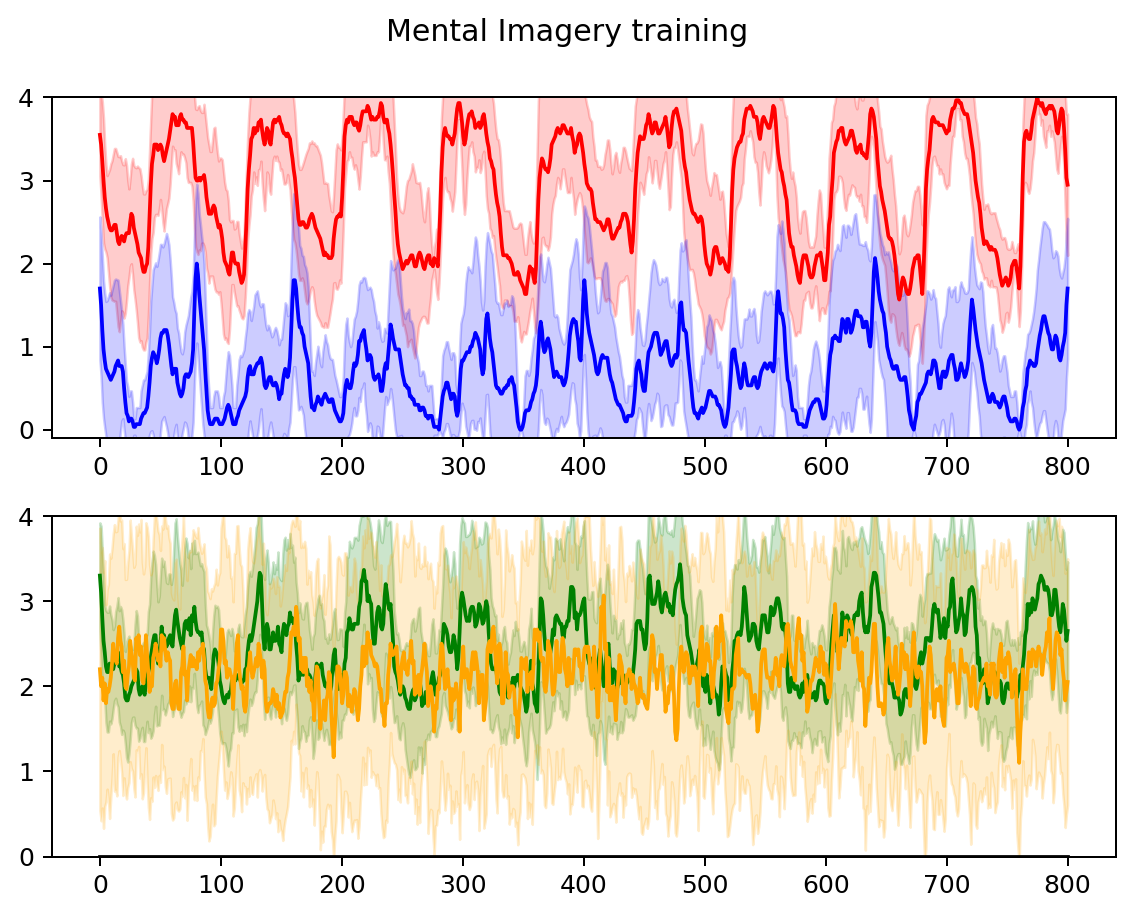

In [8]:
from model import nf_net_dist as nf_phase_layer
from model import rest_phase_layer

from tools import to_list_of_one_hots
import copy

# Loading the experimental values we're trying to match
names,scores,ts = load_eeg_scores_xp1(XP1_DATA_PATH,"eeg")



REST_CST = 0.01
def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        rh_mi = normed_intensity*np.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        lh_mi = normed_intensity*np.sin(normed_orientation*PI/2.0) + rest_cst
        return rh_mi,lh_mi

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_erd,lh_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  - (rh_erd - lh_erd)/(lh_erd + rh_erd)  # Minus
        return (aai+1)/2.0  # Normalized to 0 -> 1

def get_erd(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based on the intensity of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_mi,lh_mi = ERDs(normed_orientation,normed_intensity,krest)
        erd_estimate = (rh_mi - krest)/krest
        return erd_estimate  # Normalized to 0 -> 1

def distance_matrix_based_on_laterality(_Ns,krest=0.01,linear_dependence_on_intensity = False):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                normed_laterality = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                normed_intensity = intens/(_Ns[1]-1.0)

                aai = get_aai(normed_laterality,normed_intensity,REST_CST)
                if linear_dependence_on_intensity :
                        aai = aai * normed_intensity
                        if normed_intensity < 0.1 :
                                aai = -1
                _dist_mat[idx] = 1.0 - aai
        return _dist_mat

def distance_matrix_based_on_intensity(_Ns,krest=0.01,bypass_orientation=None):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                norm_ori = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                intensity = intens/(_Ns[1]-1.0)

                _dist_mat[idx] = get_erd(intensity,norm_ori,REST_CST)
        return _dist_mat

def training(Ntrials,_network_rest,_network_nf):
        """
        A function to describe the training procedure : 
        """
        return_stm,return_weights = [],[]

        
        def communicate(from_net,from_stm,to_net):
                # The last state of the previous iteration becomes the first of the next
                # We also transfer the learnt matrices !
                to_net.layers[1].b = copy.deepcopy(from_net.layers[1].b)
                to_net.layers[1].d = copy.deepcopy(from_net.layers[1].d)
                to_net.layers[0].d = to_list_of_one_hots(from_stm[0].x[:,-1],to_net.layers[0].Ns)

        # We gather the initial weights of the layer at index 0
        return_weights.append(_network_nf.get_current_layers_weights())
        return_stm.append(None) # To match the indices
        for trial in range(Ntrials):
                # Phase 1 : rest !
                # Assume the agent picked actions randomly and the provide:
                rest_stm,rest_wght = _network_rest.run(False,return_STMs=True,return_weights=True)
                
                # Ensure layer continuity between phases.
                communicate(_network_rest,rest_stm,_network_nf)

                nf_stm,nf_wght = _network_nf.run(False,return_STMs=True,return_weights=True)

                # Ensure layer continuity between phases.
                communicate(_network_nf,nf_stm,_network_rest)

                return_stm.append(rest_stm)
                return_stm.append(nf_stm)

                return_weights.append(rest_wght)
                return_weights.append(nf_wght)
        
        return return_stm,return_weights

T = 40  # The amount of timesteps for a specific trial
        # 20 s / 250 ms = 80 timesteps
Ntrials = 30   # 10 blocks x 3 phases
Nsubjects = 10

Th = 2  # Action planning temporal horizon
Ns_proc,Ns_subj = [5,4],[5,4]
resting_states = [int(Ns_proc[0]/2.0),0,0]
Nos = [5,5] # A single feedback with 10 distinct possible observations

# Defining the feedback properties
sigmas_proc = [0.5,0.5] # The true feedback is quite noisy
true_dist_mat = [distance_matrix_based_on_laterality(Ns_proc,linear_dependence_on_intensity = False),distance_matrix_based_on_intensity(Ns_proc)]

sigmas_subj = [0.5] # The subject expects the feedback to be not that noisy
belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = True)]
# belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = False)]
observation_concentration,observation_stickiness = 1.0,100.0

# Defining the mental states properties
N_up_actions,N_down_actions,N_neutral_actions = 1,1,10
p_decay,p_effect = 0.2,0.99
transition_concentration,transition_stickiness = 1.0,1.0
b_pre = [0.65,0.35]#[3.0*transition_concentration,1.0*transition_concentration]

network_during_nftraining = nf_phase_layer(T,Th,
        Ns_proc,Ns_subj,Nos,
        sigmas_proc,true_dist_mat,
        sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
        N_up_actions,N_down_actions,N_neutral_actions,
        p_decay,p_effect,
        transition_concentration,transition_stickiness,
        learning_space_structure=actynf.LINEAR,gen_temp=3.0,
        resting_state_per_factor=resting_states,
        b_pre=b_pre)

network_during_rest = rest_phase_layer(T,Th,
    Ns_proc,Ns_subj,Nos,
    sigmas_proc,true_dist_mat, 
    sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
    N_up_actions,N_down_actions,N_neutral_actions,
    p_decay,p_effect,
    transition_concentration,transition_stickiness,
    learning_space_structure=actynf.LINEAR,gen_temp=3.0,
    resting_state_per_factor=resting_states,
    b_pre=b_pre)

override = False
savepath = os.path.join(SAVING_FOLDER,"simu_03.simu")

# This is a straight forward run ! 
exists = os.path.isfile(savepath)
if (not(exists)) or (override):
        stm_subjs,weight_subjs = [],[]
        for sub in range(Nsubjects):
                print("Subject " + str(sub) + " / " + str(Nsubjects))
                subj_net = network_during_nftraining.copy_network(sub)
                rest_net = network_during_rest.copy_network(sub)
                STMs,weights = training(Ntrials,rest_net,subj_net)
                stm_subjs.append(STMs)
                weight_subjs.append(weights)
        save_output(stm_subjs,weight_subjs,savepath)

_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

arr_feedback_levels = np.array([[_stm[subj][trial][0].o[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the measured feedbacks ! (modality 0 : laterality, modality 1 : nf)
arr_state_levels = np.array([[_stm[subj][trial][0].x[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
arr_state_belief_levels = np.array([[_stm[subj][trial][1].x_d for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)

plotN = 20
arr_feedback_levels = arr_feedback_levels[:,-plotN:,...]
arr_state_levels = arr_state_levels[:,-plotN:,...]
arr_state_belief_levels = arr_state_belief_levels[:,-plotN:,...]
window = 1

# Mean of all subjects
fig1,axes1 = plt.subplots(2,1,dpi=180)
colorlist = ["red","blue"]
for f in range(len(Ns_proc)):
        color = colorlist[f]
        states = arr_state_levels[:,:,f,:]
        flat_state_f = states.reshape(states.shape[0],-1)
        m_state = clever_running_mean(np.mean(flat_state_f,axis=0),window)
        v_state = clever_running_mean(np.std(flat_state_f,axis=0),window)
        xs = np.linspace(0,m_state.shape[0],m_state.shape[0])
        axes1[0].fill_between(xs,m_state-v_state,m_state+v_state,color=color,alpha=0.2)
        axes1[0].plot(xs,m_state,color=color)
axes1[0].set_ylim([-0.1,max(Ns_proc)-1])

colorlist = ["green","orange","black"]

for mod in range(arr_feedback_levels.shape[2]):
        color = colorlist[mod]
        observations = arr_feedback_levels[:,:,mod,:]
        flat_fb_lvl = observations.reshape(observations.shape[0],-1)
        m_fb = clever_running_mean(np.mean(flat_fb_lvl,axis=0),window)
        v_fb = clever_running_mean(np.std(flat_fb_lvl,axis=0),window)
        xs = np.linspace(0,m_fb.shape[0],m_fb.shape[0])
        axes1[1].fill_between(xs,m_fb-v_fb,m_fb+v_fb,color=color,alpha=0.2)
        axes1[1].plot(xs,m_fb,color=color)
axes1[1].set_ylim([0,max(Nos)-1])
fig1.tight_layout()
fig1.suptitle("Mental Imagery training",y=1.05)
fig1.show()


# # Compare simulations to actual subject results !
# for subj in range(len(_stm)):
#         # Plotting the measured values:
#         subj_id = subj


#         # Plotting simulated : 
        

        
#         fig,axes = plt.subplots(3,1,dpi=180)

#         # Plot the states
#         all_states = arr_state_levels[subj]
#         print(all_states.shape)
#         all_states = np.swapaxes(all_states,0,1)
#         all_states = all_states.reshape(all_states.shape[0],-1)

#         xs = np.linspace(0,400,all_states.shape[-1])
#         # Orientation factor : 
#         axes[0].plot(xs,2*clever_running_mean(all_states[0,:],window)/(Ns_proc[0]-1) -1,label="Orientation")
#         # Intensity factor : 
#         axes[0].plot(xs,clever_running_mean(all_states[1,:],window)/(Ns_proc[1]-1),label="Intensity")


#         # Plot the simulated feedback levels, and compare them to experimental results
#         all_feedbacks = arr_feedback_levels[subj]
#         all_fbs = np.swapaxes(all_feedbacks,0,1)
#         all_fbs = all_fbs.reshape(all_fbs.shape[0],-1)

#         # Orientation feedback
#         axes[1].plot(xs,(2*clever_running_mean(all_fbs[0,:],window)/(Nos[0]-1)-1),alpha=0.5)
#         axes[1].plot(np.linspace(0,400,scores[subj_id][2].shape[0]),scores[subj_id][2],alpha=0.5)

#         # Intensity feedback
#         axes[2].plot(xs,(2*clever_running_mean(all_fbs[1,:],window)/(Nos[1]-1)-1),alpha=0.5,label="simulated nf")
#         axes[2].plot(np.linspace(0,400,scores[subj_id][3].shape[0]), np.clip(scores[subj_id][3],-1,1),alpha=0.5,label="measured nf")

#         for ax in axes :
#                 ax.grid()
#                 ax.legend()
#         fig.show()

#         A = _weight[subj][-1][0]["a"]
#         B = _weight[subj][-1][0]["b"]
#         a = _weight[subj][-1][1]["a"]
#         ainit = _weight[subj][0][1]["a"]
#         b = _weight[subj][-1][1]["b"]
#         binit = _weight[subj][0][1]["b"]
#         Nf = len(B)
#         Nu = [Bf.shape[-1] for Bf in B]
#         for factor in range(Nf):
#             plotted_actions = [-3,-2,-1]
#             fig,axs = plt.subplots(len(plotted_actions),3)
#             axs[0,0].set_title("True transition mapping")
#             axs[0,1].set_title("Initial transition belief")
#             axs[0,2].set_title("Final transition belief")
#             for action_idx in range(len(plotted_actions)):
#                 action = plotted_actions[action_idx]
#                 axs[action,0].imshow(actynf.normalize(B[factor][...,action]),vmin=0,vmax=1)
#                 axs[action,1].imshow(actynf.normalize(binit[factor][...,action]),vmin=0,vmax=1)
#                 axs[action,2].imshow(actynf.normalize(b[factor][...,action]),vmin=0,vmax=1)
#             fig.show()
        
#         obs_state_fact = A[0].shape[-1]
#         fig,axes = plt.subplots(obs_state_fact,3)
#         axes[0,0].set_title("True FB mapping")
#         axes[0,1].set_title("Initial FB belief")
#         axes[0,2].set_title("Final FB belief")
#         for factor in range(obs_state_fact):
#             axes[factor,0].imshow(actynf.normalize(A[0][:,:,factor]),vmin=0,vmax=1)
#             axes[factor,1].imshow(actynf.normalize(ainit[0][:,:,factor]),vmin=0,vmax=1)
#             axes[factor,2].imshow(actynf.normalize(a[0][:,:,factor]),vmin=0,vmax=1)
#         fig.show()
#         print(all_fbs.shape)


(60, 2, 40)
(10, 2, 2400)
(10, 2400)


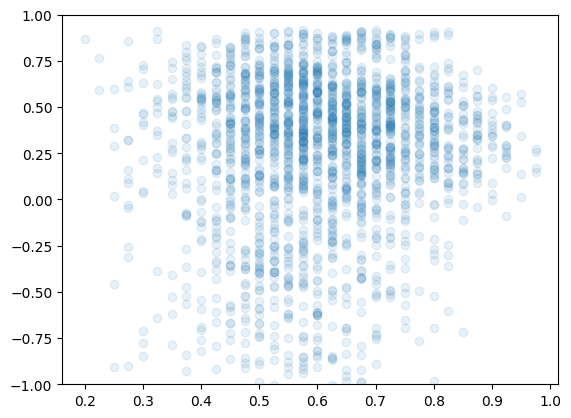

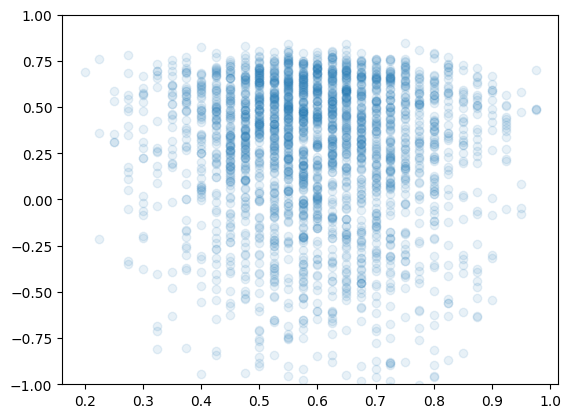

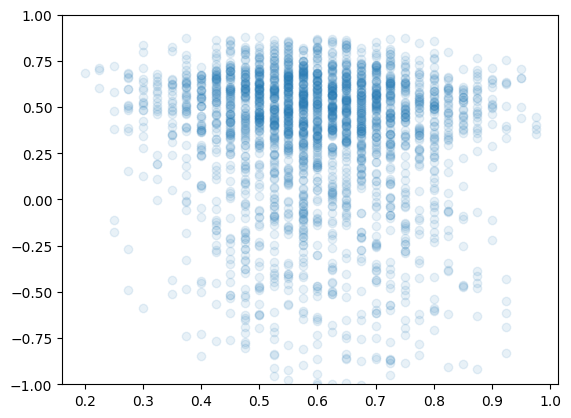

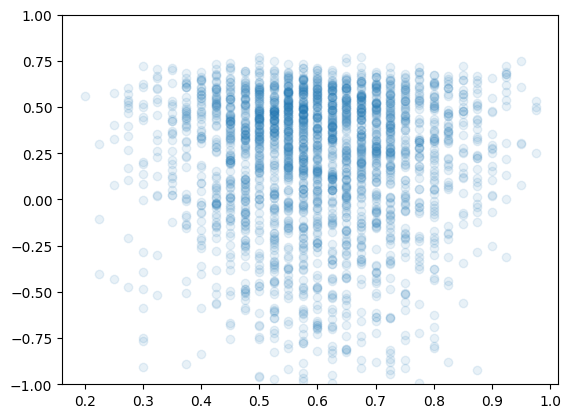

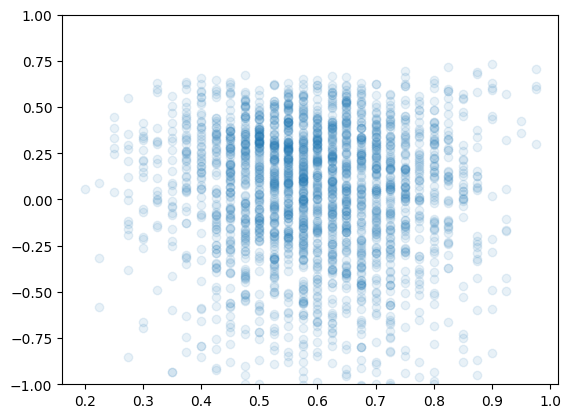

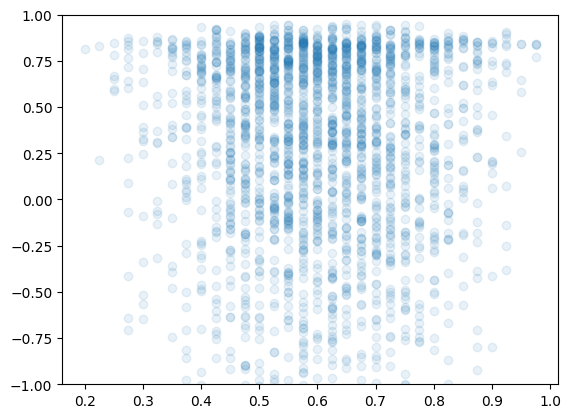

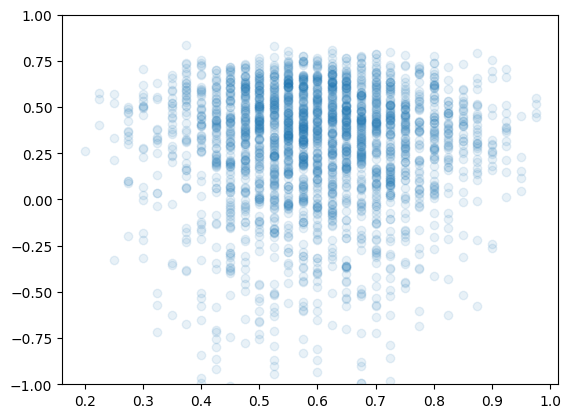

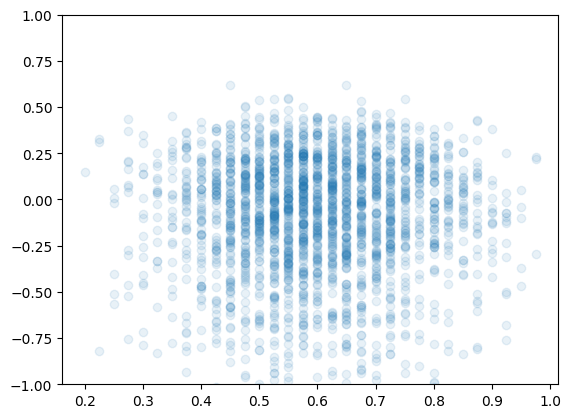

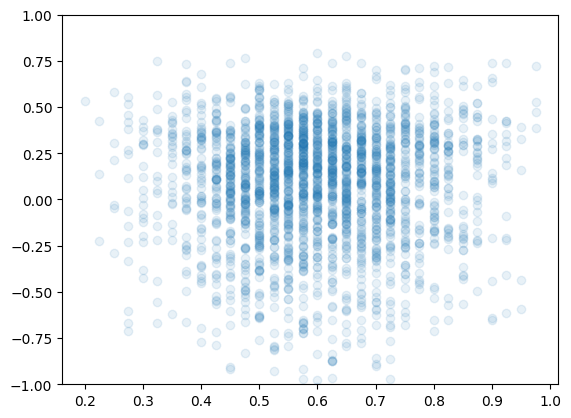

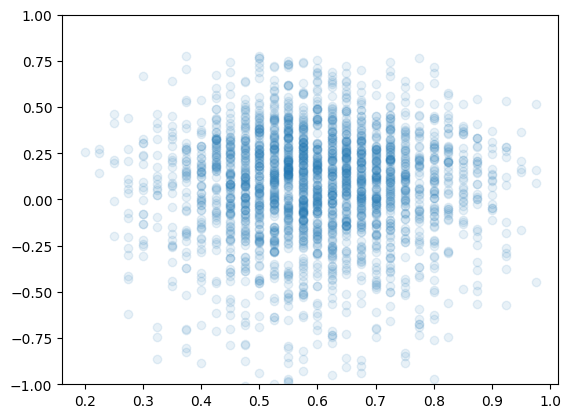

In [9]:
from model import nf_net_dist as nf_phase_layer
from model import rest_phase_layer

from tools import to_list_of_one_hots
import copy

from load_data import get_full_training_in_order


# Defining the training loop :
REST_CST = 0.01
def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        rh_mi = normed_intensity*np.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        lh_mi = normed_intensity*np.sin(normed_orientation*PI/2.0) + rest_cst
        return rh_mi,lh_mi

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_erd,lh_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  - (rh_erd - lh_erd)/(lh_erd + rh_erd)  # Minus
        return (aai+1)/2.0  # Normalized to 0 -> 1

def get_erd(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based on the intensity of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        rh_mi,lh_mi = ERDs(normed_orientation,normed_intensity,krest)
        erd_estimate = (rh_mi - krest)/krest
        return erd_estimate  # Normalized to 0 -> 1

def distance_matrix_based_on_laterality(_Ns,krest=0.01,linear_dependence_on_intensity = False):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                normed_laterality = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                normed_intensity = intens/(_Ns[1]-1.0)

                aai = get_aai(normed_laterality,normed_intensity,REST_CST)
                if linear_dependence_on_intensity :
                        aai = aai * normed_intensity
                        if normed_intensity < 0.1 :
                                aai = -1
                _dist_mat[idx] = 1.0 - aai
        return _dist_mat

def distance_matrix_based_on_intensity(_Ns,krest=0.01,bypass_orientation=None):
        _dist_mat = np.zeros(tuple(_Ns))
        for idx,val in np.ndenumerate(_dist_mat):
                ori,intens = idx[0],idx[1]

                norm_ori = ori/(_Ns[0]-1.0)
                        # From 0 to 1, how much orientated to the right is the mental imagery of the subject ?
                intensity = intens/(_Ns[1]-1.0)

                _dist_mat[idx] = get_erd(intensity,norm_ori,REST_CST)
        return _dist_mat

def training(Ntrials,_network_rest,_network_nf):
        """
        A function to describe the training procedure : 
        """
        return_stm,return_weights = [],[]

        
        def communicate(from_net,from_stm,to_net):
                # The last state of the previous iteration becomes the first of the next
                # We also transfer the learnt matrices !
                to_net.layers[1].b = copy.deepcopy(from_net.layers[1].b)
                to_net.layers[1].d = copy.deepcopy(from_net.layers[1].d)
                to_net.layers[0].d = to_list_of_one_hots(from_stm[0].x[:,-1],to_net.layers[0].Ns)

        # We gather the initial weights of the layer at index 0
        return_weights.append(_network_nf.get_current_layers_weights())
        return_stm.append(None) # To match the indices
        for trial in range(Ntrials):
                # Phase 1 : rest !
                # Assume the agent picked actions randomly and the provide:
                rest_stm,rest_wght = _network_rest.run(False,return_STMs=True,return_weights=True)
                
                # Ensure layer continuity between phases.
                communicate(_network_rest,rest_stm,_network_nf)

                nf_stm,nf_wght = _network_nf.run(False,return_STMs=True,return_weights=True)

                # Ensure layer continuity between phases.
                communicate(_network_nf,nf_stm,_network_rest)

                return_stm.append(rest_stm)
                return_stm.append(nf_stm)

                return_weights.append(rest_wght)
                return_weights.append(nf_wght)
        
        return return_stm,return_weights

T = 40  # The amount of timesteps for a specific trial
        # 20 s / 250 ms = 80 timesteps
Ntrials = 30   # 10 blocks x 3 phases
Nsubjects = 10

Th = 2  # Action planning temporal horizon
Ns_proc,Ns_subj = [5,4],[5,4]
resting_states = [int(Ns_proc[0]/2.0),0,0]
Nos = [5,5] # A single feedback with 10 distinct possible observations

# Defining the feedback properties
sigmas_proc = [0.5,0.5] # The true feedback is quite noisy
true_dist_mat = [distance_matrix_based_on_laterality(Ns_proc,linear_dependence_on_intensity = False),distance_matrix_based_on_intensity(Ns_proc)]

sigmas_subj = [0.5] # The subject expects the feedback to be not that noisy
belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = True)]
# belief_dist_mat = [distance_matrix_based_on_laterality(Ns_subj,linear_dependence_on_intensity = False)]
observation_concentration,observation_stickiness = 1.0,100.0

# Defining the mental states properties
N_up_actions,N_down_actions,N_neutral_actions = 1,1,10
p_decay,p_effect = 0.2,0.99
transition_concentration,transition_stickiness = 1.0,1.0
b_pre = [0.65,0.35]#[3.0*transition_concentration,1.0*transition_concentration]

network_during_nftraining = nf_phase_layer(T,Th,
        Ns_proc,Ns_subj,Nos,
        sigmas_proc,true_dist_mat,
        sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
        N_up_actions,N_down_actions,N_neutral_actions,
        p_decay,p_effect,
        transition_concentration,transition_stickiness,
        learning_space_structure=actynf.LINEAR,gen_temp=3.0,
        resting_state_per_factor=resting_states,
        b_pre=b_pre)

network_during_rest = rest_phase_layer(T,Th,
    Ns_proc,Ns_subj,Nos,
    sigmas_proc,true_dist_mat, 
    sigmas_subj,belief_dist_mat,observation_concentration,observation_stickiness,
    N_up_actions,N_down_actions,N_neutral_actions,
    p_decay,p_effect,
    transition_concentration,transition_stickiness,
    learning_space_structure=actynf.LINEAR,gen_temp=3.0,
    resting_state_per_factor=resting_states,
    b_pre=b_pre)

override = False
savepath = os.path.join(SAVING_FOLDER,"simu_04_fit.simu")

# This is a straight forward run ! 
exists = os.path.isfile(savepath)
if (not(exists)) or (override):
        stm_subjs,weight_subjs = [],[]
        for sub in range(Nsubjects):
                print("Subject " + str(sub) + " / " + str(Nsubjects))
                subj_net = network_during_nftraining.copy_network(sub)
                rest_net = network_during_rest.copy_network(sub)
                STMs,weights = training(Ntrials,rest_net,subj_net)
                stm_subjs.append(STMs)
                weight_subjs.append(weights)
        save_output(stm_subjs,weight_subjs,savepath)

_stm,_weight,_Nsubj,_Ntrials = extract_training_data(savepath)

arr_feedback_levels = np.array([[_stm[subj][trial][0].o[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the measured feedbacks ! (modality 0 : laterality, modality 1 : nf)
arr_state_levels = np.array([[_stm[subj][trial][0].x[:,:] for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
arr_state_belief_levels = np.array([[_stm[subj][trial][1].x_d for trial in range(1,len(_stm[subj]))] for subj in range(Nsubjects)])
        # All the true cognitive states ! (factor 0 : orientation of MI ERDs, factor 1 : intensity of MI ERDs)
print(arr_state_levels[0].shape)

# Refactor the states :
# subj = 0
# all_states = arr_state_levels[subj]
# print(all_states.shape)
all_states = np.swapaxes(arr_state_levels,1,2)
all_states = all_states.reshape(all_states.shape[0],all_states.shape[1],-1)
print(all_states.shape)

all_fbs = np.swapaxes(arr_feedback_levels,1,2)
all_fbs = all_fbs.reshape(all_fbs.shape[0],all_fbs.shape[1],-1)
synthetic_nf = all_fbs[:,1,:]
synthetic_nf_lat = all_fbs[:,0,:]

synthetic_nf = np.mean(synthetic_nf,axis=0)
print(synthetic_nf_lat.shape)

# Loading the experimental values we're trying to match
names,nf_eeg,nf_bold,ts = get_full_training_in_order(XP1_DATA_PATH,metric_idx = [3,4])
# names,nf_eeg_smoothed,bold,ts = get_full_training_in_order(XP1_DATA_PATH,metric_idx = [4,4])
# Downsampling : 
eeg = np.array(nf_eeg)
downsampled_eeg = eeg.reshape(eeg.shape[0],-1,synthetic_nf_lat.shape[-1]).mean(axis=1)

def model_f(x,a,b):
        return a*x + b

from scipy.optimize import curve_fit


for subj in range(len(nf_eeg)):
        
        subject_nf = downsampled_eeg[subj,:]
        plt.scatter(synthetic_nf/4.0,subject_nf,alpha = 0.1)
        plt.ylim([-1,1])
        plt.show()
# print(synthetic_nf)
# print(downsampled_eeg)
# params, covariance = curve_fit(model_f,synthetic_nf , downsampled_eeg)
# print(params)
# print(downsampled_eeg.shape)
# for trial in range(1,Ntrials,2):
#     print(trial)
#     first_trial = np.sum(arr_state_belief_levels[0][trial,:,:,:],axis=1)
#     print(first_trial.shape)
#     print(np.round(first_trial,2))

# plotN = 20
# arr_feedback_levels = arr_feedback_levels[:,-plotN:,...]
# arr_state_levels = arr_state_levels[:,-plotN:,...]
# arr_state_belief_levels = arr_state_belief_levels[:,-plotN:,...]
# window = 1






## References

<a id="0">[0]</a> 
Simultaneous MRI-EEG during a motor imagery neurofeedback task: an open access brain imaging dataset for multi-modal data integration
Giulia Lioi, Claire Cury, Lorraine Perronnet, Marsel Mano, Elise Bannier, Anatole Lécuyer,  View ORCID ProfileChristian Barillot
doi: https://doi.org/10.1101/862375

<a id="1">[1]</a> 
Karl Friston, Lancelot Da Costa, Danijar Hafner, Casper Hesp, Thomas Parr; 
Sophisticated Inference. Neural Comput 2021; 33 (3): 713–763. doi: https://doi.org/10.1162/neco_a_01351

<a id="2">[2]</a> 
Bart VKE, Koch I, Rieger M. Inhibitory mechanisms in motor imagery: disentangling different forms of inhibition using action mode switching. Psychol Res. 2021;85(4):1418-1438. doi:10.1007/s00426-020-01327-y